# Song Classification

> Deep Learning Cookbook: Practical Recipes to Get Started Quickly 15.1 & 15.2

## 为音乐分类器创建训练数据集

In [89]:
import os
import random
import numpy as np

SEED = 1

random.seed(SEED)
np.random.seed(SEED)

加拿大维多利亚大学的 genres 数据集，不同风格各 100 个片段（.wav 文件），每段 30 秒。

Download the dataset manually:

```shell
cd /Volumes/shared/murecom/intro
aria2c -s16 -x16 -k1M http://opihi.cs.uvic.ca/sound/genres.tar.gz
tar xzf genres.tar.gz
```

下载下来有些多余的 mf 文件，把他们移走：

```shell
$ cd genres
$ ls
bextract_single.mf co.mf              hiphop             metal              ro.mf
bl.mf              country            input.mf           po.mf              rock
blues              di.mf              ja.mf              pop
cl.mf              disco              jazz               re.mf
classical          hi.mf              me.mf              reggae
$ mkdir ../genres_mf
$ mv *.mf ../genres_mf/
$ ls
blues     country   hiphop    metal     reggae
classical disco     jazz      pop       rock
```

利用 `librosa` 制作梅尔频谱图（melspectrogram），一种模拟人类听觉工作原理的频谱：

In [90]:
import os
import librosa


def listdir(path: os.PathLike[str]) -> list[str]:
    """os.listdir with ".DS_Store" removed

    :param path: a str, bytes, or a path-like object
    :return: a list containing the names of the files in the directory.
    """
    ls = os.listdir(path)
    try:
        ls.remove(".DS_Store")
    except ValueError as e:
        pass
    return ls


def load_song(song_folder):
    song_specs = []  # array shape (1000, 1280, 128)
    idx_to_genre = []  # {g for g in ls}
    genre_to_idx = {}  # {v: k for k, v in enumerate(ls)}
    genres = []  # [j for j in range(10) for i in range(10)]

    for genre in listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in listdir(genre_folder):
            if song.endswith(".wav"):
                signal, sr = librosa.load(
                    os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(
                    signal, sr=sr).T[:1280, ]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])

    return song_specs, genres, genre_to_idx, idx_to_genre


song_specs, genres, genre_to_idx, idx_to_genre = load_song("/Volumes/shared/murecom/intro/genres")

In [105]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)


def show_spectrogram(genre_name):
    genre_idx = genre_to_idx[genre_name]
    specs = []
    for spec, idx in zip(song_specs, genres):
        if idx == genre_idx:
            specs.append(spec)
            if len(specs) >= 25:
                break
    if not specs:
        raise ValueError("specs not found")
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x * 20).clip(0, 1.0))

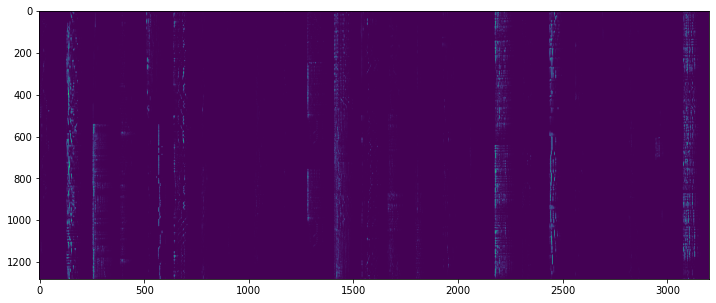

In [106]:
show_spectrogram("classical")

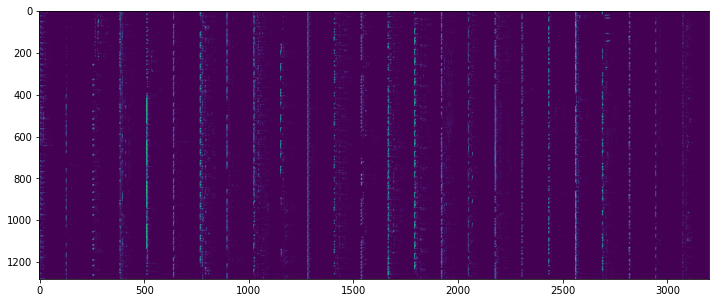

In [107]:
show_spectrogram("hiphop")

只能说，不同风格有不同频谱，但人力从可视化结果中看不出来太多的信息，所以我们希望神经网络可以看出点什么来。

## 训练音乐风格检测器

用一维卷积网络来学习频谱。

In [94]:
import tensorflow as tf

tf.random.set_seed(SEED)

In [95]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import SGD


def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs

    # 一维卷积池化堆叠
    levels = 64
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2

    # Global -> shape(128)
    x = GlobalMaxPooling1D()(x)

    # 计算类型标签的全连接网络
    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])

    # optimizer and compile model
    sgd = SGD(learning_rate=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model = cnn_model((128, 128))
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128)]        0         
                                                                 
 conv1d_18 (Conv1D)          (None, 126, 64)           24640     
                                                                 
 batch_normalization_18 (Bat  (None, 126, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 batch_normalization_19 (Bat  (None, 61, 128)          512 

考虑到我们只有 1000 个歌曲样本，为了增加数据量，我们把每首歌分成 10 个 三秒钟的片段。

In [96]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)

又是分 10 类，上 one-hot：

In [97]:
from tensorflow.keras.utils import to_categorical

genres_one_hot = to_categorical(genres, num_classes=len(genre_to_idx))

准备数据集：

In [98]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot),
    test_size=0.1, stratify=genres)

x_train, y_train = split_10(x_train, y_train)
x_test, y_test = split_10(x_test, y_test)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

训练

In [99]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=3,
                           verbose=0,
                           mode='auto')

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop])

Epoch 1/100
71/71 [==============================] - 8s 98ms/step - loss: 3.4246 - accuracy: 0.1440 - val_loss: 2.2110 - val_accuracy: 0.2270
Epoch 2/100
71/71 [==============================] - 7s 96ms/step - loss: 2.3649 - accuracy: 0.2022 - val_loss: 2.0763 - val_accuracy: 0.2940
Epoch 3/100
71/71 [==============================] - 7s 94ms/step - loss: 2.1802 - accuracy: 0.2373 - val_loss: 1.9944 - val_accuracy: 0.3170
Epoch 4/100
71/71 [==============================] - 7s 94ms/step - loss: 2.0798 - accuracy: 0.2624 - val_loss: 1.9183 - val_accuracy: 0.3230
Epoch 5/100
71/71 [==============================] - 7s 93ms/step - loss: 2.0372 - accuracy: 0.2697 - val_loss: 1.8685 - val_accuracy: 0.3460
Epoch 6/100
71/71 [==============================] - 7s 93ms/step - loss: 2.0116 - accuracy: 0.2798 - val_loss: 1.8282 - val_accuracy: 0.3610
Epoch 7/100
71/71 [==============================] - 7s 93ms/step - loss: 1.9624 - accuracy: 0.2968 - val_loss: 1.7899 - val_accuracy: 0.3750
Epoch 

In [100]:
model.save('song_classify.h5')

只有差不多 56% 的准确率.

之前不是给他分成 10 份了嘛，现在我们要综合 10 份的信息，得到对原本 30s 的片段的预测。
直观的想法是做个多数投票，或者更简单，直接取最大值：

In [101]:
from sklearn.metrics import accuracy_score


def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.66

这样准确率提高了一点了。

## 对混淆情况进行可视化

做一个混淆矩阵：

- 列：每种风格真值；
- 行：预测结果；

In [103]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[68  0  1  6  1  0  5 14  1  0]
 [ 1 70  4  6  6  0  8  3  8  1]
 [ 2  8 77  0  9  0  4  2  2  0]
 [ 1  2  0 49  9  1 10  1  8  6]
 [ 3  4  4  9 54  0  0 10  6  0]
 [ 1  0  0  2 10 81 11  0  6  8]
 [ 3 14  7  6  0  1 25 11  6  1]
 [20  0  7  1 10  0  4 57  0  0]
 [ 1  2  0 16  0  2 22  0 50  9]
 [ 0  0  0  5  1 15 11  2 13 75]]


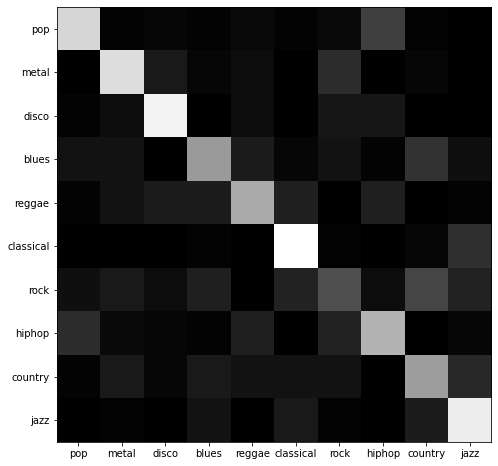

In [108]:
plt.imshow(cm.T, interpolation='nearest', cmap='gray')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

从中可以看出，网络很好地区分了古典乐，而对摇滚不能很好的分类。